## Use bonus plates (length of 4)
## Important notes:
### - new color model: number of channels = 4, one channel for each color  
### - plate value encoded with a number: 0.1, 0.4, 1.0  
### - v3.2: all helpers moved to external module
### - v3.2: hint restored: s_before is now field after 'make_move'
### - v3.3: debugging CNN since learning doesn't work
### - v3.4: try bigger CNN 
### - v3.5: problem found. Large space of moves just doesn't work. Reduce to 1

In [10]:
# Needed for tests and a real game against the phone
#import pandas as pd
#import qgrid

import random as rd
import numpy as np
import tensorflow as tf

from collections import deque

import environment as ae

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Constants

In [11]:
# CNN
LEARNING_RATE = 0.001
DYNAMIC_LEARNING_EPOCHS = 5
MINIBATCH_SIZE = 128
UPDATE_TARGET_NET = 1000
GAMMA = 0.95
REWARD_SCALER = 100.

# Definitions
GAMES_TO_PLAY = 131072
REPLAY_MEMORY_SIZE = 8192
NUMBER_OF_MOVES_IN_GAME = 50

# Variables
MAXIMUM_SCORE = 0
CNN_MOVE_PROB = 0.1
CNN_MOVES_COUNT = 0
CNN_SUCCESSFUL_PREDICTION = 0
AGG_GAMES_NUMBER = 10
TOTAL_SCORE_AGG = 0.0
TOTAL_SUCCESSFUL_MOVES_AGG = 0.0

### Replay Memory Buffer

In [12]:
#
# Replay memory buffer
#
class ExperienceBuffer():
    '''
    Experience Replay Buffer
    Inspired by Andrea Lonza
    '''

    def __init__(self, buffer_size, gamma):
        # Constants
        self.gamma = gamma
        
        # Main Replay Memory buffer parts
        self.states_before = deque(maxlen=buffer_size)
        self.actions = deque(maxlen=buffer_size)
        self.total_rewards = deque(maxlen=buffer_size)
        self.states_after = deque(maxlen=buffer_size)
        self.last_moves = deque(maxlen=buffer_size)
   
    
    def add(self, state_before, action, reward, state_after, last_move):
        # Add certain items to corresponding buffers
        self.states_before.append(state_before)
        self.actions.append(action)
        self.total_rewards.append(reward)
        self.states_after.append(state_after)
        self.last_moves.append(last_move)
    
    
    def sample_minibatch(self, minibatch_size):
        '''
        Sample a minibatch of size batch_size
        Note1: always add the most recent completed move
        '''
        indices = rd.sample(range(len(self.states_before) - 1), minibatch_size - 1)
        # Add the most recent completed move index
        indices.append(len(self.states_before) - 1)
        
        minibatch_states_before = np.array([self.states_before[i] for i in indices]) 
        minibatch_actions = np.array([self.actions[i] for i in indices]) 
        minibatch_total_rewards = np.array([self.total_rewards[i] for i in indices]) 
        minibatch_states_after = np.array([self.states_after[i] for i in indices])  
        minibatch_last_moves = np.array([self.last_moves[i] for i in indices])   
        
        return minibatch_states_before, minibatch_actions, minibatch_total_rewards, minibatch_states_after, minibatch_last_moves
    
    
    def __len__(self):
        '''
        Return length of the current replay memory buffer
        Relevant for the first *minibatch_size* moves.
        '''
        return len(self.states_before)
    
    
    def max_rewards(self):
        """
        Returns max reward in the current buffer
        """
        maximum_value = 0
        
        for i in self.total_rewards:
            if (i > maximum_value):
                maximum_value = i
                
        return maximum_value
    
            
    

## Deep Q-Nework

### Initialize Replay Buffer

In [13]:
replay_memory = ExperienceBuffer(REPLAY_MEMORY_SIZE, GAMMA)

### Initialize Online CNN and Target CNN

In [14]:
tf.random.set_seed(8)

# Initialize optimizer
online_cnn_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)


# Online CNN
inputs = tf.keras.Input(shape=(7, 6, 4), batch_size=MINIBATCH_SIZE)

x = tf.keras.layers.Conv2D(128, kernel_size=3, strides = (1, 1), padding='valid', activation=tf.nn.relu, data_format='channels_last', kernel_initializer='HeNormal')(inputs)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, strides = (1, 1), padding='valid', activation=tf.nn.relu, data_format='channels_last', kernel_initializer='HeNormal')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_initializer='HeNormal')(x)
x = tf.keras.layers.BatchNormalization()(x)

outputs = tf.keras.layers.Dense(ae.ACTIONS_DIMENSION, activation=tf.nn.softmax)(x)

Online_CNN = tf.keras.Model(inputs=inputs, outputs=outputs)

# Online CNN
#Online_CNN = tf.keras.models.Sequential()
#Online_CNN.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides = (1, 1), padding='valid', activation=None, data_format='channels_last', kernel_initializer='HeNormal', input_shape=(7, 6, 4)))
#Online_CNN.add(tf.keras.layers.Activation("relu"))
#Online_CNN.add(tf.keras.layers.BatchNormalization())

#Online_CNN.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides = (1, 1), padding='valid', activation=None, data_format='channels_last', kernel_initializer='HeNormal', input_shape=(7, 6, 4)))
#Online_CNN.add(tf.keras.layers.Activation("relu"))
#Online_CNN.add(tf.keras.layers.BatchNormalization())

#Online_CNN.add(tf.keras.layers.Flatten())        

#Online_CNN.add(tf.keras.layers.Dense(64, activation=None, kernel_initializer='HeNormal'))
#Online_CNN.add(tf.keras.layers.Activation("relu"))
#Online_CNN.add(tf.keras.layers.BatchNormalization())

#Online_CNN.add(tf.keras.layers.Dense(ae.ACTIONS_DIMENSION, activation=None, kernel_initializer='HeNormal'))
#Online_CNN.add(tf.keras.layers.Activation("softmax"))


#Online_CNN.compile(optimizer=online_cnn_optimizer, loss="mean_squared_error")



# Target CNN
#Target_CNN = tf.keras.models.Sequential()
#Target_CNN.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides = (1, 1), padding='same', activation=tf.keras.activations.tanh, data_format = 'channels_last', kernel_initializer='RandomNormal', input_shape=(7, 6, 4)))
#Target_CNN.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides = (1, 1), padding='same', activation=tf.keras.activations.tanh, kernel_initializer='RandomNormal'))    
#Target_CNN.add(tf.keras.layers.Flatten())                      
#Target_CNN.add(tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_initializer='RandomNormal'))
#Target_CNN.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='RandomNormal'))

#Target_CNN.compile(optimizer=online_cnn_optimizer, loss="mean_squared_error")


# Set weights equal
#Target_CNN.set_weights(Online_CNN.get_weights())

# Just to see how many trainable parameters
#Online_CNN.summary()

In [15]:
def loss(model, X, y_true, A):
    prediction = model(X)
    selected_action_values = tf.math.reduce_sum(prediction*A, axis=1)  
    return tf.keras.losses.MSE(y_true, selected_action_values)


def grad(model, inputs, targets, actions):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, actions)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Dynamic Learning

In [16]:
%%time

FOUND = False

# Number of moves made to follow the target CNN update strategy
total_moves = 1
                                                      
for game in range(5): #GAMES_TO_PLAY):
    # Start one game
    game_score = 0
    successful_moves = 0
    
    print("New game")

    # Initialize the game field
    field = np.zeros((7, 6, 4))
    field = ae.initialize_field_3D(field)

    for m in range(NUMBER_OF_MOVES_IN_GAME):
        # Total score of one move
        reward = 0

        # Whether CNN made the move
        cnn_made_move_flag = False
        
        # If replay_memory has less than 64 moves, then make a random move
        if ((len(replay_memory) < MINIBATCH_SIZE) or (rd.random() > CNN_MOVE_PROB)):
            move = rd.randint(1, ae.ACTIONS_DIMENSION)
        else:
            # CNN selects a move
            cnn_made_move_flag = True
            CNN_MOVES_COUNT = CNN_MOVES_COUNT + 1
            #
            # Predict the move using the hint
            #
            #_, move = ae.predict_max_score_3D(field.copy(), Target_CNN, ae.ACTIONS_DIMENSION, ae.MOVES)
            #_, move = ae.predict_max_score_3D(field.copy(), Online_CNN, ae.ACTIONS_DIMENSION, ae.MOVES)
            #
            # Predict the move without the hint
            #
            move = np.argmax(Online_CNN(np.expand_dims(field.copy(), axis=0))) + 1
            
        # Make the move
        new_field, plate_a, plate_b = ae.make_move_v2_3D(field.copy(), move, ae.MOVES)
        field_after_move = new_field.copy()

        # Calculate the score and update the field
        score, new_field = ae.calculate_score_v2_3D(new_field, plate_a, plate_b)
        
        # If the move is successful, then update the field and check if we have new sets        
        successful_move_flag = False

        # While we have new sets (thus the score is greater than 0), process them, calculate score and move plates
        while (score > 0.):
            if (not successful_move_flag):
                successful_moves = successful_moves + 1
                successful_move_flag = True

            # Add new points to the total score of the move
            reward = reward + score

            # Move plates downward, fill the upper row so, that it doesn't have "easy" sets of three
            # Start from the left lower corner (in order to reuse color_fits())
            new_field = ae.fill_field_3D(new_field)

            # Calculate score and check whether we have new sets
            score, new_field = ae.calculate_score_v2_3D(new_field, (-1, -1), (-1, -1))

        # Increase the score of the whole game
        game_score = game_score + reward
        
        # Check whether it's the last move of the current game
        last_move = m == NUMBER_OF_MOVES_IN_GAME - 1         

        # Add new move to the replay memory
        if (successful_move_flag):
            replay_memory.add(field, move, reward / REWARD_SCALER, new_field, last_move)
            
            # Update CNN move statistics
            if (cnn_made_move_flag):    
                CNN_SUCCESSFUL_PREDICTION = CNN_SUCCESSFUL_PREDICTION + 1               
                
        else:
            replay_memory.add(field, move, 0, field, last_move)   
        
        #
        # Train CNN based on the score
        #
        if (len(replay_memory) >= MINIBATCH_SIZE):
            # Select random MINIBATCH_SIZE moves from replay memory buffer
            samples = replay_memory.sample_minibatch(MINIBATCH_SIZE)

            # Prepare some things for training
            s_before = samples[0]
            actions = samples[1]
            rewards = samples[2]
            s_after = samples[3] 
            dones = samples[4]
            
            # Carefully predict next rewards: we must use predict_max_score
            rewards_next = np.zeros((MINIBATCH_SIZE))
            
            for item in range(MINIBATCH_SIZE):
                # Calculate future rewards ONLY if current reward is NOT zero, otherwise no sense
                if (rewards[item] > 0):
                    #
                    # Predict the move using the hint
                    #
                    #rewards_next[item], _ = ae.predict_max_score_3D(s_after[item], Target_CNN, ae.ACTIONS_DIMENSION, ae.MOVES)
                    #rewards_next[item], _ = ae.predict_max_score_3D(s_after[item], Online_CNN, ae.ACTIONS_DIMENSION, ae.MOVES)
                    #
                    # Predict the move without the hint
                    #
                    rewards_next[item] = np.max(Online_CNN(np.expand_dims(s_after[item], axis=0)))
                    
            #
            # Update online CNN weights: training step
            #
            actual_values = np.where(dones, rewards, rewards + GAMMA*rewards_next)
            
            selected_actions = tf.one_hot(actions - 1, ae.ACTIONS_DIMENSION)
            
            for _ in range(DYNAMIC_LEARNING_EPOCHS):             
                loss_value, grads = grad(Online_CNN, s_before, actual_values, selected_actions)
                online_cnn_optimizer.apply_gradients(zip(grads, Online_CNN.trainable_variables))
                
                #if (game % AGG_GAMES_NUMBER == 0):
                #    print(loss_value)
            
            #
            # This method is unstable: I couldn't make it work regularly
            #
            #history = Online_CNN.fit(x=s_before, y=actual_values, epochs=DYNAMIC_LEARNING_EPOCHS, verbose=0)
            #loss_value = history.history["loss"]
            
            # DEBUG: Trying to find a reason of NaN
            for layer in Online_CNN.layers:
                weights = layer.get_weights()
                for w in weights:
                    if (np.isnan(w).sum() > 0):
                        FOUND = True
                        break
                if (FOUND):
                    break
                    
        if (FOUND):
            print("NaN value found!")
            break

        # If move is successful, update the play field
        if (successful_move_flag):
            field = np.copy(new_field)
            
        # After each UPDATE_TARGET_NET moves update target CNN
        #if (total_moves % UPDATE_TARGET_NET == 0):
        #    Target_CNN.set_weights(Online_CNN.get_weights())
            
        total_moves = total_moves + 1

    if (FOUND):
        break
        
    #
    # Calculate and display overall stats
    #
    # Check whether we have new maximum score
    if (game_score > MAXIMUM_SCORE):
        print(f"New maximum: {game_score}, after {game} games.")
        MAXIMUM_SCORE = game_score
        
    # After each AGG_GAMES_NUMBER games output average game score, average number of successful moves per game
    TOTAL_SCORE_AGG = TOTAL_SCORE_AGG + game_score
    TOTAL_SUCCESSFUL_MOVES_AGG = TOTAL_SUCCESSFUL_MOVES_AGG + successful_moves
    
    if ((game % AGG_GAMES_NUMBER == 0) and (game > 0)):
        avg_score = TOTAL_SCORE_AGG / AGG_GAMES_NUMBER
        TOTAL_SCORE_AGG = 0.0
        
        avg_succ_moves = TOTAL_SUCCESSFUL_MOVES_AGG / AGG_GAMES_NUMBER
        TOTAL_SUCCESSFUL_MOVES_AGG = 0.0

        print(f"Games: {game}, last {AGG_GAMES_NUMBER} games avg score: {avg_score}, avg of succ moves: {avg_succ_moves}")        
        print(f"CNN made {CNN_MOVES_COUNT} moves. Successful were {CNN_SUCCESSFUL_PREDICTION}")
        print(f"rewards_next is {rewards_next.sum()}")
        
        if (CNN_SUCCESSFUL_PREDICTION / CNN_MOVES_COUNT >= CNN_MOVE_PROB):
            CNN_MOVE_PROB = CNN_MOVE_PROB + 0.1
            
        CNN_MOVES_COUNT = 0
        CNN_SUCCESSFUL_PREDICTION = 0


New game
New maximum: 36, after 0 games.
New game
New game
New maximum: 71, after 2 games.
New game
New game
CPU times: user 23.7 s, sys: 948 ms, total: 24.6 s
Wall time: 19.8 s


In [17]:
rewards

array([0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.03,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.06,
       0.03, 0.  , 0.  , 0.  , 0.03, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.03, 0.03, 0.  , 0.  , 0.  , 0.05, 0.03, 0.  , 0.03, 0.  , 0.  ,
       0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05,
       0.03, 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.1 , 0.  , 0.  , 0.03, 0.03,
       0.  , 0.  , 0.06, 0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.03, 0.03, 0.  , 0.  , 0.1 ,
       0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

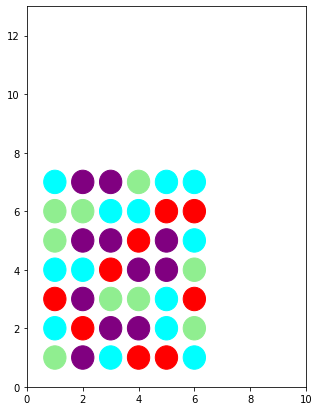

In [18]:
ae.visualize_field_3D(s_before[3])

In [23]:
ae.MOVES[13]

((1, 3), (2, 3))

In [40]:
for _ in range(DYNAMIC_LEARNING_EPOCHS):             
    loss_value, grads = grad(Online_CNN, s_before, actual_values, selected_actions)
    online_cnn_optimizer.apply_gradients(zip(grads, Online_CNN.trainable_variables))
    print(loss_value.numpy())

0.000123031
0.00013559662
0.00015397434
0.00016784354
0.00017199114


In [43]:
np.max(Online_CNN(np.expand_dims(s_before[3], axis=0)))

0.71655905

In [ ]:
rewards[0]

In [ ]:
selected_actions[0]

In [ ]:
prediction = Online_CNN(s_before)
A = tf.one_hot(actions - 1, ae.ACTIONS_DIMENSION)

selected_action_values = tf.math.reduce_sum(prediction*A, axis=1)  
print(selected_action_values[0])

In [ ]:
prediction[0]

In [ ]:
rewards

In [ ]:
replay_memory.max_rewards()

In [ ]:
np.where(dones, rewards, rewards + GAMMA*rewards_next)

In [ ]:
Online_CNN.predict(np.expand_dims(s_before[1], axis=0))

In [ ]:
np.isnan(s_before).sum()

In [ ]:
for layer in Online_CNN.layers:
    weights = layer.get_weights()
    print(weights)

In [ ]:
m = 0

for i in replay_memory:
    if (i[2] > m):
        m = i[2]
        
print(m)

## Debuggin the Hint

In [ ]:
# Total score of one move
reward = 0

# Whether CNN made the move
cnn_made_move_flag = False

# If replay_memory has less than 64 moves, then make a random move
if ((len(replay_memory) < MINIBATCH_SIZE) or (rd.random() > CNN_MOVE_PROB)):
    move = rd.randint(1, ae.ACTIONS_DIMENSION)
else:
    # CNN selects a move
    cnn_made_move_flag = True
    CNN_MOVES_COUNT = CNN_MOVES_COUNT + 1
    scr, move = ae.predict_max_score_3D(field.copy(), Target_CNN, ae.ACTIONS_DIMENSION, ae.MOVES)
    print(f"Predicted move {move} with score of {scr}")

In [ ]:
# Make the move
new_field, plate_a, plate_b = ae.make_move_v2_3D(field.copy(), move, ae.MOVES)
field_after_move = new_field.copy()

# Calculate the score and update the field
score, new_field = ae.calculate_score_v2_3D(new_field, plate_a, plate_b)

# If the move is successful, then update the field and check if we have new sets        
successful_move_flag = False

# While we have new sets (thus the score is greater than 0), process them, calculate score and move plates
while (score > 0.):
    if (not successful_move_flag):
        successful_moves = successful_moves + 1
        successful_move_flag = True

    # Add new points to the total score of the move
    reward = reward + score

    # Move plates downward, fill the upper row so, that it doesn't have "easy" sets of three
    # Start from the left lower corner (in order to reuse color_fits())
    new_field = ae.fill_field_3D(new_field)

    # Calculate score and check whether we have new sets
    score, new_field = ae.calculate_score_v2_3D(new_field, (-1, -1), (-1, -1))

print(reward)


In [ ]:

#
# Train CNN based on the score
#

samples = replay_memory.sample_minibatch(MINIBATCH_SIZE)

# Prepare some things for training
s_before = samples[0]
actions = samples[1]
rewards = samples[2]
s_after = samples[3] 
dones = samples[4]


In [ ]:
def loss(model, X, y_true, A):
    prediction = model(X)
    selected_action_values = tf.math.reduce_sum(prediction*A, axis=1)  
    return tf.keras.losses.MSE(y_true, selected_action_values)


def grad(model, inputs, targets, actions):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, actions)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
rewards_next = np.max(Target_CNN(s_after), axis=1)
actual_values = np.where(dones, rewards, rewards + GAMMA*rewards_next)
selected_actions = tf.one_hot(actions, ae.ACTIONS_DIMENSION)

In [ ]:
loss_value, grads = grad(Online_CNN, s_before, actual_values, selected_actions)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(), loss_value.numpy()))

optimizer.apply_gradients(zip(grads, Online_CNN.trainable_variables))

print("Step: {}, Loss: {}".format(optimizer.iterations.numpy(), loss(Online_CNN, s_before, actual_values, selected_actions).numpy()))

### Now the CNN has been trained.
### Start the long reinforcement-learning cycle

In [ ]:
successful_moves

In [ ]:
new_field = make_move(field, move)
print(new_field)

In [ ]:
temp_field = calculate_score(new_field)

In [ ]:
new_field = np.multiply(new_field, 1.0 - temp_field)

In [ ]:
fill_field(new_field, colors)

In [ ]:
#
# Save model
#
# v1: 20190329, trained on len(replay_memory) = 294912
#aero_cnn.save("Aero_CNN_v1")

## Backup

In [ ]:
#
# Create the moves dictionary
#
moves = {}

for i in range(1, 143):
    old_row, old_column, old_direction = process_move_142(i)
    
    start_row = old_row - 1
    start_col = old_column - 1
    
    if (old_direction == "down"):
        end_row = start_row + 1
        end_col = start_col
    elif (old_direction == "up"):
        end_row = start_row - 1
        end_col = start_col
    elif (old_direction == "right"):
        end_row = start_row
        end_col = start_col + 1
    else:
        end_row = start_row
        end_col = start_col - 1
        
    moves[i] = ((start_row, start_col), (end_row, end_col))
    
print(moves)